In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE
import numpy as np
#import jplus



Using TensorFlow backend.
/Users/aaorsi/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


In [2]:
#load databases

#DataDir = './data/'
DataDir = '.'
import pickle
dset = pickle.load(open('%s/training_full.data'%DataDir))
print dset.keys()
ngal = len(dset['class'])
print ngal
dset_original = dset.copy() # keeping a copy of original datapoints for 


['rSDSS', 'iSDSS', 'obj', 'gSDSS', 'J0395', 'zSDSS', 'J0378', 'J0430', 'uSDSS', 'dm_j0660', 'J0660', 'J0410', 'J0515', 'J0861', 'class']
751


** Here I add the option to resample all datasets sampling from their photometric errors. Each new sample has attribute $m$ drawn from a Gaussian with $\mu = m$ and $\sigma = \delta_m$, where $\delta_m$ is the photometric error of the attribute $m$.

In [48]:
Resample_errors = True

Split_test = 0.2 # Separate fraction to use for testing.

ids_shuffled = np.random.permutation(np.arange(ngal))
# TODO: remove a fixed fraction from all classes. Then, keep those as a separate dictionary, 
# and use the rest to build a resampled set as below.

nr = 10 #sampling each object nr times.
if Resample_errors:
    print 'Re-sampling dset %d times'%nr
    rs_dset = {} #dictionary storing resamplings
    for key in dset.keys():
        rs_dset[key] = []
    for i in range(ngal):
        for key in dset.keys():
            rs_dset[key].append(dset[key][i]) #First add the original object
            for j in range(nr):
                if len(dset[key][i]) ==2:
                    rs_dset[key].append([np.random.normal(dset[key][i,0], 
                                        np.max([dset[key][i,1],0])),dset[key][i,1]])
                else:
                    rs_dset[key].append(dset[key][i])
    for key in dset.keys():
        rs_dset[key] = np.array(rs_dset[key])
            
    dset = rs_dset
    
    print 'done'


Re-sampling dset 10 times
done


In [49]:
print len(dset['class']), 11*ngal

8261 8261


In [50]:
featnames = ['dm_j0660','J0378','J0395','J0410','J0430','J0515',
             'J0660','J0861','uSDSS','gSDSS','rSDSS','iSDSS','zSDSS']

ntrain = len(dset['obj'])
feat_arr = []

import itertools

terms = featnames[1:] # create all colour combinations
nterms = len(terms)
ncomb = int(nterms*(nterms-1)/2.)
print 'All colours:', ncomb
comb = list(itertools.combinations(terms,2))
lcomb = list(comb)
colournames = ['%s - %s'%(x[0], x[1]) for x in list(comb)]

for x in range(ntrain):
    fx = []
    for y in featnames:
        fx.append(dset[y][x,0])
    for z in range(ncomb):
        fx.append(dset[lcomb[z][0]][x,0] - dset[lcomb[z][1]][x,0])
        
#    fx.append(dset['uSDSS'][x,0]-dset['gSDSS'][x,0])
#    fx.append(dset['gSDSS'][x,0]-dset['rSDSS'][x,0])
#    fx.append(dset['rSDSS'][x,0]-dset['iSDSS'][x,0])
#    fx.append(dset['uSDSS'][x,0]-dset['gSDSS'][x,0])
#    fx.append(dset['iSDSS'][x,0]-dset['zSDSS'][x,0])
#    fx.append(dset['uSDSS'][x,0]-dset['zSDSS'][x,0])
#    fx.append(dset['rSDSS'][x,0]-dset['zSDSS'][x,0])
    
    feat_arr.append(fx)
class_arr = dset['class']
featnames += colournames

All colours: 66


In [44]:
%debug



> <ipython-input-43-a5ec1835a9b6>(20)<module>()
     18     fx = []
     19     for y in featnames:
---> 20         fx.append(dset[y][x,0])
     21     for z in range(ncomb):
     22         fx.append(dset[lcomb[z][0]][x,0] - dset[lcomb[z][1]][x,0])

ipdb> print dset[y][x]
[0.4238423  0.04010769]
ipdb> print y
dm_j0660
ipdb> print dset[y][x,0]
*** TypeError: list indices must be integers, not tuple
ipdb> print np.array(dset[y])[x,0]
0.42384229559276676
ipdb> q


In [51]:
#Example sets

def class_to_int(istr):
    if istr == 'Halpha':
        return 0
    elif istr == 'OIII+Hbeta':
        return 1
    if istr == 'OII':
        return 2
    elif istr == 'contaminant':
        return 3
    else:
        print '%s not recognised'%istr
        return -99

    
def int_to_class(i):
    if i == 0:
        return 'Halpha'
    elif i == 1:
        return 'OIII+Hbeta'
    elif i == 2:
        return 'OII'
    elif i == 3:
        return 'contaminant'
    else:
        print '%d not recognised'%i
        return 'None'


y_train_int = [class_to_int(x) for x in class_arr]
y_train_cat = keras.utils.to_categorical(y_train_int, num_classes=len(np.unique(y_train_int)))
x_train = feat_arr
nfeat = len(feat_arr[0])




***Before resampling, I'll look at the Feature Importances from Extra Trees***

The following is adapted from Sklearn's example of Feature Importances in

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


Feature ranking:
1. feature 10 (0.040918): $rSDSS$
2. feature 6 (0.039613): $J0660$
3. feature 9 (0.038209): $gSDSS$
4. feature 76 (0.029170): $rSDSS - iSDSS$
5. feature 5 (0.026776): $J0515$
6. feature 62 (0.025376): $J0660 - iSDSS$
7. feature 4 (0.023490): $J0430$
8. feature 74 (0.022903): $gSDSS - iSDSS$
9. feature 69 (0.020142): $uSDSS - gSDSS$
10. feature 11 (0.019295): $iSDSS$
11. feature 3 (0.018346): $J0410$
12. feature 70 (0.017484): $uSDSS - rSDSS$
13. feature 59 (0.017121): $J0660 - uSDSS$
14. feature 46 (0.016145): $J0430 - uSDSS$
15. feature 2 (0.015843): $J0395$
16. feature 60 (0.015336): $J0660 - gSDSS$
17. feature 53 (0.015152): $J0515 - uSDSS$
18. feature 56 (0.014728): $J0515 - iSDSS$
19. feature 44 (0.014369): $J0430 - J0660$
20. feature 58 (0.013722): $J0660 - J0861$
21. feature 7 (0.013384): $J0861$
22. feature 1 (0.013052): $J0378$
23. feature 65 (0.012827): $J0861 - gSDSS$
24. feature 12 (0.012678): $zSDSS$
25. feature 49 (0.012589): $J0430 - iSDSS$
26. feature 8

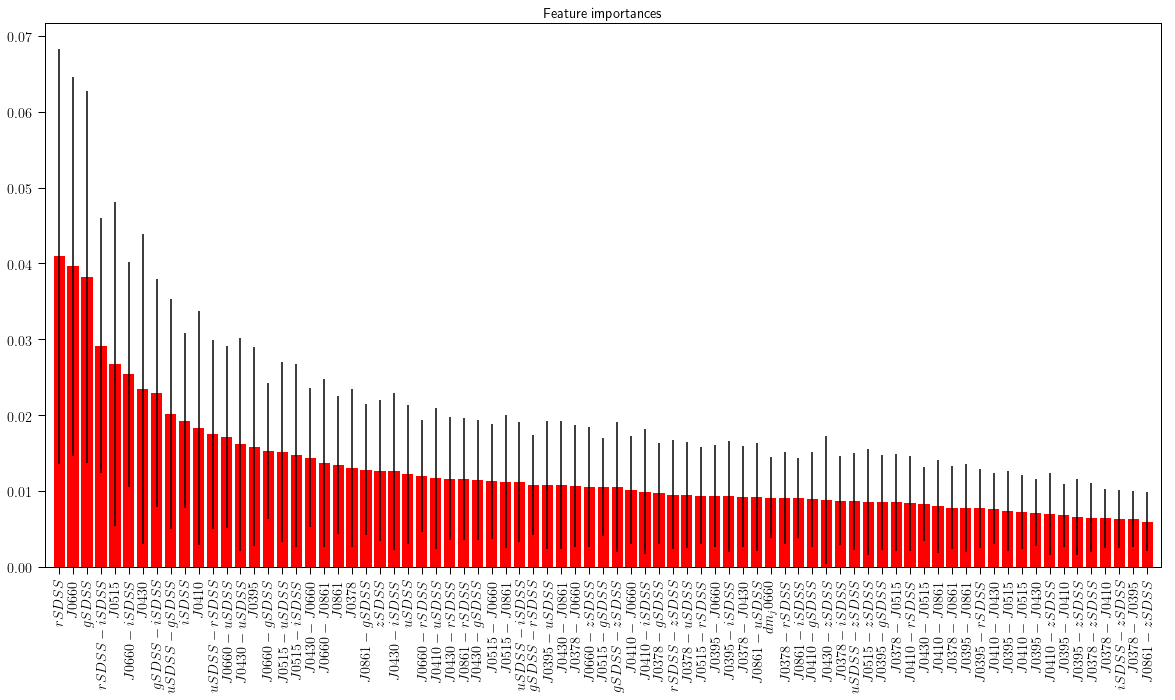

In [53]:
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=1323)

x_train = np.array(x_train)
forest.fit(x_train, y_train_int)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
inames = [r'$%s$'%featnames[x] for x in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], inames[f]))


# Plot the feature importances of the forest
plt.figure(1, figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]),inames,rotation='vertical')
plt.xlim([-1, x_train.shape[1]])
plt.show()

# Filter those below a given threshold

threshold = 0.015






In [54]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train_int, test_size=0.2, random_state=1324)


X_res, y_res = SMOTE(sampling_strategy='not majority').fit_resample(X_train, y_train)
print(sorted(Counter(y_res).items()))

y =  keras.utils.to_categorical(y_res, num_classes=len(np.unique(y_res)))
yt = keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))

print y[0]

[(0, 5879), (1, 5879), (2, 5879), (3, 5879)]
[0. 0. 0. 1.]


Scale data using scikit-learn StandardScaler

In [55]:
from sklearn.preprocessing import StandardScaler 
Scaledata = True

if Scaledata:
    print 'scaling data...',
    scaler = StandardScaler()
    scaler.fit(X_res)
    x_train = scaler.transform(X_res)
    x_test = scaler.transform(X_test)
    #x_test  = scaler.transform(x_test)
    print 'done'


scaling data... done


In [56]:
# Balance the training set by sub-sampling the contaminant class
Balance = False
if Balance:
    all_classes = [0,1,2,3]
    nclass = []
    selclass = []
    yarr = np.asarray(y_train_int)
    for ic in all_classes:
        sel = np.where(np.asarray(yarr) == ic)[0]
        nclass.append(len(yarr[sel]))
        selclass.append(sel)


    idd = list(np.random.choice(selclass[3], nclass[2]))
    print idd, yarr[idd]
    nff = sum(nclass)

    new_idd = []
    for ic in [0,1,2]:
        sel = np.where(yarr == ic)[0]
        new_idd += list(sel)

    new_idd += idd

    y_new = np.asarray([y_train[x] for x in new_idd])
    x_new = np.asarray([x_train[x] for x in new_idd])



In [57]:
# Keras MLP

from keras import metrics

model = Sequential()
model.add(Dense(nfeat/3, activation='sigmoid', input_dim=nfeat))
#model.add(Dropout(0.2))
model.add(Dense(nfeat/2, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 26)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 39)                1053      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 160       
Total params: 3,293
Trainable params: 3,293
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(x_train, y,
          shuffle=True,
          verbose=1,
          epochs=10,
          batch_size=50
          )



Epoch 1/10
23516/23516 [==============================] - 4s 166us/step - loss: 0.6638
Epoch 2/10
23516/23516 [==============================] - 2s 86us/step - loss: 0.2777
Epoch 3/10
23516/23516 [==============================] - 2s 87us/step - loss: 0.1818
Epoch 4/10
23516/23516 [==============================] - 2s 104us/step - loss: 0.1291
Epoch 5/10
23516/23516 [==============================] - 2s 94us/step - loss: 0.0992
Epoch 6/10
23516/23516 [==============================] - 2s 88us/step - loss: 0.0813
Epoch 7/10
23516/23516 [==============================] - 2s 89us/step - loss: 0.0690
Epoch 8/10
23516/23516 [==============================] - 2s 89us/step - loss: 0.0600
Epoch 9/10
23516/23516 [==============================] - 2s 89us/step - loss: 0.0531
Epoch 10/10
23516/23516 [==============================] - 2s 89us/step - loss: 0.0478


In [59]:
score = model.evaluate(x_test,yt)
pred = model.predict(x_test)
pred_class = [np.argmax(x) for x in pred]
y_new_num = [np.argmax(x) for x in yt]
print pred[0]

print y_new_num[0], pred_class[0]

1653/1653 [==============================] - 0s 144us/step
[8.1088615e-04 4.7370072e-06 4.0235234e-05 9.9914408e-01]
3 3


In [60]:
from sklearn.metrics import f1_score

score = f1_score(y_new_num, pred_class,average=None, labels=[2], pos_label=2)
print score
pred_names = [int_to_class(x) for x in range(4)]
print pred_names



[0.79432624]
['Halpha', 'OIII+Hbeta', 'OII', 'contaminant']


/Users/aaorsi/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


**Here I try GridSearchCV**

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers

def build_classifier(optim='sgd',drop=0.0,Neurons=nfeat,init='uniform'):
   #   from keras.optimizers import SGD
    model = Sequential()
    model.add(Dense(Neurons, input_dim=nfeat, kernel_initializer=init, activation='sigmoid'))
    model.add(Dropout(drop))
    model.add(Dense(Neurons/2, activation='sigmoid'))
#    model.add(Dropout(drop))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim)
    return model

seed = 7132
np.random.seed(seed)

model = KerasClassifier(build_fn=build_classifier, verbose=0)

optim = ['sgd','adam']#,'rmsprop','sgd'] #['rmsprop', 'adam']
init = ['uniform']#['glorot_uniform', 'normal', 'uniform']
epochs = [10, 20]
batches = [50,100]#,200,500]#,500]#, 500]
dropout = [.1]#1e-3,1e-2,1e-1]#,0.5,0.75]
Neurons = [nfeat/2]
param_grid = dict(optim=optim, epochs=epochs, batch_size=batches, init=init,drop=dropout,
                 Neurons=Neurons)



In [14]:
print y[0]

[0. 0. 0. 1.]


In [18]:
from sklearn.metrics import make_scorer, fbeta_score,f1_score

# pos_label below optimises the f score for a particular label
f2_score = make_scorer(fbeta_score, beta=1,average='macro')
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring=f2_score,verbose=10,n_jobs=4)
grid_result = grid.fit(x_train, y_res)

best= grid_result.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done  20 out of  24 | elapsed:  1.0min remaining:   12.1s
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  1.2min finished


In [25]:
y_pred = best.predict(x_train, verbose=1)

score = f1_score(y_res,y_pred,average=None, labels=range(4))
print score
pred_names = [int_to_class(x) for x in range(4)]
print pred_names

y_pt = best.predict(x_test, verbose=1)

score = f1_score(y_new_num,y_pt,average=None, labels=range(4))
print score
pred_names = [int_to_class(x) for x in range(4)]
print pred_names




1848/1848 [==============================] - 0s 35us/step
[0.98717949 0.98189563 0.95020747 0.91015169]
['Halpha', 'OIII+Hbeta', 'OII', 'contaminant']
226/226 [==============================] - 0s 78us/step
[0.57142857 0.15384615 0.54545455 0.89304813]
['Halpha', 'OIII+Hbeta', 'OII', 'contaminant']


In [23]:
df = grid_result.cv_results_
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))




Best: 0.382194 using {'optim': 'adam', 'drop': 0.1, 'batch_size': 50, 'epochs': 20, 'init': 'uniform', 'Neurons': 39}
0.096303 (0.136194) with: {'optim': 'sgd', 'drop': 0.1, 'batch_size': 50, 'epochs': 10, 'init': 'uniform', 'Neurons': 39}
0.272857 (0.032636) with: {'optim': 'adam', 'drop': 0.1, 'batch_size': 50, 'epochs': 10, 'init': 'uniform', 'Neurons': 39}
0.082085 (0.116085) with: {'optim': 'sgd', 'drop': 0.1, 'batch_size': 50, 'epochs': 20, 'init': 'uniform', 'Neurons': 39}
0.382194 (0.178128) with: {'optim': 'adam', 'drop': 0.1, 'batch_size': 50, 'epochs': 20, 'init': 'uniform', 'Neurons': 39}
0.041133 (0.058170) with: {'optim': 'sgd', 'drop': 0.1, 'batch_size': 100, 'epochs': 10, 'init': 'uniform', 'Neurons': 39}
0.240718 (0.011006) with: {'optim': 'adam', 'drop': 0.1, 'batch_size': 100, 'epochs': 10, 'init': 'uniform', 'Neurons': 39}
0.055749 (0.078841) with: {'optim': 'sgd', 'drop': 0.1, 'batch_size': 100, 'epochs': 20, 'init': 'uniform', 'Neurons': 39}
0.275809 (0.035041) wi